# Intro
Введение
В настоящем ноутбуке приведена исследовательская часть проекта.

# Import
Импорт библиотек

In [82]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import logging
logging.getLogger('sklearnex').setLevel(logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.ERROR)

from sklearnex import patch_sklearn
patch_sklearn(verbose=False)

from urllib.parse import urlencode
import keras
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score as precision
from sklearn.metrics import recall_score as recall
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Matplotlib settings
Настройки matplotlib

In [2]:
matplotlib.rcParams['figure.facecolor'] = [0.08, 0.09, 0.10]
matplotlib.rcParams['axes.facecolor'] = [0.09, 0.10, 0.11]
matplotlib.rcParams['axes.edgecolor'] = [0.8, 0.8, 0.8]
matplotlib.rcParams['axes.labelcolor'] = [0.8, 0.8, 0.8]
matplotlib.rcParams['xtick.color'] = [0.8, 0.8, 0.8]
matplotlib.rcParams['ytick.color'] = [0.8, 0.8, 0.8]
matplotlib.rcParams['legend.edgecolor'] = [0.8, 0.8, 0.8]
matplotlib.rcParams['legend.facecolor'] = [0.09, 0.10, 0.11]
matplotlib.rcParams['text.color'] = [0.8, 0.8, 0.8]

# Classes and functions
Классы и функции

## class Client

In [3]:
class Client:
    def __init__(self) -> None:
        self.session = requests.Session()

    def get_bars(self,
                 ticker: str,
                 frame: str,
                 start_ts: int | None = None,
                 end_ts: int | None = None,
                 limit: int | None = 499) -> list[list]:

        """
        limit [1,100) ---> weight = 1\n
        limit [100, 500) ---> weight = 2\n
        limit [500, 1_000] ---> weight = 5\n
        limit (1_000, 1_500} ---> weight = 10\n
        """

        # region Проверка входных параметров
        if type(ticker) != str:
            msg = 'type(ticker) != str'
            raise Exception(msg)

        if ticker != ticker.upper():
            msg = 'ticker != ticker.upper()'
            raise Exception(msg)

        frames = '1m 3m 5m 15m 30m 1h 2h 4h 6h 8h 12h 1d 3d 1w 1M'.split()
        if frame not in frames:
            msg = f'frame not in {frames}'
            raise Exception(msg)

        if type(start_ts) not in (int, type(None)):
            msg = 'type(start_ts) not in (int, type(None))'
            raise Exception(msg)

        if start_ts is not None and start_ts < 0:
            msg = 'start_ts < 0'
            raise Exception(msg)

        if type(end_ts) not in (int, type(None)):
            msg = 'type(end_ts) not in (int, type(None))'
            raise Exception(msg)

        if end_ts is not None and end_ts < 0:
            msg = 'end_ts < 0'
            raise Exception(msg)

        if start_ts is not None and end_ts is not None and end_ts < start_ts:
            msg = 'end_ts < start_ts'
            raise Exception(msg)

        if type(limit) not in (int, type(None)):
            msg = 'type(limit) not in (int, type(None))'
            raise Exception(msg)

        if limit is not None and limit < 1:
            msg = 'limit < 1'
            raise Exception(msg)

        if limit is not None and limit > 1_500:
            msg = 'limit > 1_500'
            raise Exception(msg)
        # endregion

        base_url = 'https://fapi.binance.com'
        endpoint = '/fapi/v1/klines'
        params = {
            'symbol': ticker,
            'interval': frame,
            'startTime': start_ts,
            'endTime': end_ts,
            'limit': limit
        }
        url = base_url + endpoint + '?' + urlencode(params)
        response = self.session.get(url)
        data = response.json()

        return data

## get_bars

In [96]:
def get_bars(ticker: str,
             frame: str,
             total_bars: int) -> list[list]:

    batch_size = 499
    client = Client()
    bars = []

    limit = min(batch_size, total_bars)
    batch = client.get_bars(ticker=ticker, frame=frame, limit=limit)
    bars.extend(batch)
    s = len(bars)
    r = len(bars) / total_bars * 100
    print(f'Bars downloaded: {s:,} ({r:.1f} %).', end='\r')

    while len(bars) < total_bars:
        end_ts = batch[0][0]
        limit = min(batch_size, total_bars - len(bars) + 1)
        batch = client.get_bars(ticker=ticker, frame=frame, end_ts=end_ts, limit=limit)
        batch = batch[:-1]
        bars.extend(batch)
        s = len(bars)
        r = len(bars) / total_bars * 100
        print(f'Bars downloaded: {s:,} ({r:.1f} %).', end='\r')

    return bars

## def get_rsi

In [5]:
def get_rsi(df, window):
    delta = df['close_price'] - df['open_price']
    u = delta.apply(lambda x: 1 if x > 0 else 0)
    d = delta.apply(lambda x: 1 if x < 0 else 0)
    u_ema = u.ewm(span=window, adjust=False, min_periods=window).mean()
    d_ema = d.ewm(span=window, adjust=False, min_periods=window).mean()
    sum_ud_ema = u_ema + d_ema
    sum_ud_ema = sum_ud_ema.replace(0, np.nan)
    rsi = u_ema / sum_ud_ema
    return rsi

## def get_sth

In [6]:
def get_sth(df, window):
    roll_max = df['high_price'].rolling(window=window).max()
    roll_min = df['low_price'].rolling(window=window).min()
    roll_range = roll_max - roll_min
    roll_range = roll_range.replace(0, np.nan)
    sth = (df['close_price'] - roll_min) / roll_range
    return sth

## get_balanced_weights

In [7]:
def get_balanced_weights(y: np.ndarray) -> np.ndarray:
    classes, counts = np.unique(ar=y, return_counts=True)
    weights = counts.min() / counts
    classes_weights = {c: w for c, w in zip(classes, weights)}
    balanced_weights = np.array([classes_weights[c] for c in y])

    return balanced_weights

## class MLP

In [8]:
class MLP:
    def __init__(self,
                 layer_sizes: list[int],
                 epochs: int = 200,
                 batch_size: int = 32,
                 patience: int = 10,
                 is_unbalance: bool = True) -> None:

        model = Sequential()
        for layer_size in layer_sizes:
            model.add(Dense(units=layer_size, activation='tanh'))
        model.add(Dense(units=1, activation='sigmoid'))
        model.compile(
            keras.optimizers.Adam(learning_rate=0.01),
            loss='binary_crossentropy'
        )
        self.model = model
        self.layer_sizes = layer_sizes
        self.epochs = epochs
        self.batch_size = batch_size
        self.patience = patience
        self.is_unbalance = is_unbalance

    def fit(self, x, y):
        callbacks = [EarlyStopping(monitor='loss', patience=self.patience)]
        sample_weight = get_balanced_weights(y) if self.is_unbalance else None
        self.model.fit(
            x=x, y=y, epochs=self.epochs, batch_size=self.batch_size,
            sample_weight=sample_weight, callbacks=callbacks, verbose=0
        )

    def predict_proba(self, x):
        t = self.model.predict(x, verbose=0)
        ft = np.hstack([1 - t, t])
        return ft

    def predict(self, x):
        p = (self.model.predict(x, verbose=0) > 0.5).astype(int).flatten()
        return p

## def get_pipeline

In [9]:
def get_pipeline(transformer, model):
    steps = [('transformer', transformer), ('model', model)]
    pipeline = Pipeline(steps=steps)

    return pipeline

## def cross_val_scores

In [10]:
def cross_val_scores(estimator, x, y, scoring, cv):
    scores = []
    for train_indices, test_indices in cv.split(x):
        x_train = x.loc[train_indices, ]
        y_train = y.loc[train_indices, ]
        x_test = x.loc[test_indices, ]
        y_test = y.loc[test_indices, ]
        estimator.fit(x_train, y_train)
        p_test = estimator.predict(x_test)
        score = scoring(y_test, p_test)
        scores.append(score)

    return np.array(scores)

## def permutation_importances

In [11]:
def permutation_importances(estimator, x, y, scoring, n_repeats):
    importances_mat = []
    features = []
    p = estimator.predict(x)
    s = scoring(y, p)

    for col in x:
        features.append(col)
        importances_col = []
        for i in range(n_repeats):
            buf_x = x.apply(lambda x: x.sample(frac=1).reset_index(drop=True) if x.name == col else x)
            buf_p = estimator.predict(buf_x)
            buf_s = scoring(y, buf_p)
            importance = s - buf_s
            importances_col.append(importance)
        importances_mat.append(importances_col)
    importances = np.array(importances_mat)

    return {
        'features': np.array(features),
        'importances_mean': importances.mean(axis=1),
        'importances_std': importances.std(axis=1),
        'importances': importances
    }

# Data downloading
Загрузка данных

In [12]:
TICKER = 'BTCUSDT'
FRAME = '1h'
TOTAL_BARS = 8_760

In [97]:
data = None
try:
    data = get_bars(ticker=TICKER, frame=FRAME, total_bars=TOTAL_BARS)
except Exception as e:
    print(e)

# Dataframe creating
Создание датафрейма

In [14]:
types = {
    'open_ts': np.int64,
    'open_price': np.float64,
    'high_price': np.float64,
    'low_price': np.float64,
    'close_price': np.float64,
    'base_volume': np.float64,
    'close_ts': np.int64,
    'quote_volume': np.float64,
    'total_trades': np.int64,
    'taker_buy_base_volume': np.float64,
    'taker_buy_quote_volume': np.float64,
    'ignore': 'string'
}

In [15]:
columns = list(types.keys())
df = None
try:
    df = pd.DataFrame(data=data, columns=columns)
except Exception as e:
    print(e)

In [16]:
df.head(3)

,open_ts,open_price,high_price,low_price,close_price,base_volume,close_ts,quote_volume,total_trades,taker_buy_base_volume,taker_buy_quote_volume,ignore
0,1701266400000,38106.90,38175.80,37768,37808.90,21955.358,1701269999999,832915936.34906,198695,10154.755,385265274.46500,0
1,1701270000000,37809,37879.70,37551.80,37817.60,33208.085,1701273599999,1252292316.39774,264843,16742.777,631424854.28261,0
2,1701273600000,37817.60,37866.60,37641,37752.10,14582.267,1701277199999,550382952.29094,138509,7504.187,283255786.99454,0


In [17]:
df.shape

(8760, 12)

# Type conversion
Приведение типов

In [18]:
try:
    df = df.astype(dtype=types, errors='raise')
except Exception as e:
    print(e)

In [19]:
df.dtypes

open_ts                            int64
open_price                       float64
high_price                       float64
low_price                        float64
close_price                      float64
base_volume                      float64
close_ts                           int64
quote_volume                     float64
total_trades                       int64
taker_buy_base_volume            float64
taker_buy_quote_volume           float64
ignore                    string[python]
dtype: object

# Data sorting
Сортировка данных
Обязательная процедура.

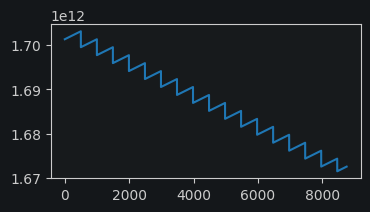

In [20]:
df['open_ts'].plot(figsize=[4, 2]);

In [21]:
df = df.sort_values(by='open_ts', ascending=True)
df = df.reset_index(drop=True)

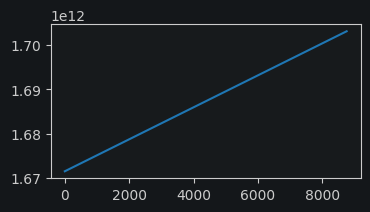

In [22]:
df['open_ts'].plot(figsize=[4, 2]);

In [23]:
start_dt = pd.to_datetime(df['open_ts'].min(), unit='ms').strftime('%d-%m-%y %H-%M')
start_dt

'20-12-22 09-00'

In [24]:
end_dt = pd.to_datetime(df['open_ts'].max(), unit='ms').strftime('%d-%m-%y %H-%M')
end_dt

'20-12-23 08-00'

# Data validation
Проверка данных

In [25]:
df.drop(columns='ignore').le(0).any().any()

False

In [26]:
df.isna().any().any()

False

In [27]:
df['open_ts'].diff().value_counts(dropna=False)

open_ts
3600000.0    8759
NaN             1
Name: count, dtype: int64

# Visualization
Визуализация

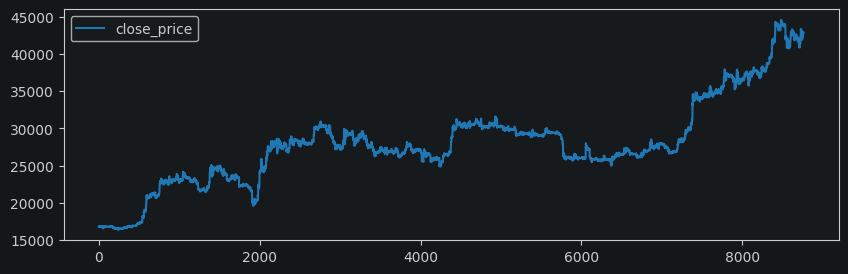

In [28]:
df[['close_price']].plot(figsize=[10, 3]);

# Work dataframe
Рабочий датафрейм

In [29]:
columns = ['open_ts', 'open_price', 'high_price', 'low_price', 'close_price']
df = df.loc[:, columns]
df.head(3)

,open_ts,open_price,high_price,low_price,close_price
0,1671526800000,16817.3,16853.0,16790.2,16806.6
1,1671530400000,16806.7,16821.8,16756.4,16769.6
2,1671534000000,16769.7,16838.8,16755.2,16805.1


# Target variable
Целевая переменная

In [30]:
TARGET_LIM = 0.2

In [31]:
change = df['close_price'] / df['open_price'] * 100 - 100
df['target'] = change.apply(lambda x: 1 if x > TARGET_LIM else 0)

In [32]:
df.head(3)

,open_ts,open_price,high_price,low_price,close_price,target
0,1671526800000,16817.3,16853.0,16790.2,16806.6,0
1,1671530400000,16806.7,16821.8,16756.4,16769.6,0
2,1671534000000,16769.7,16838.8,16755.2,16805.1,1


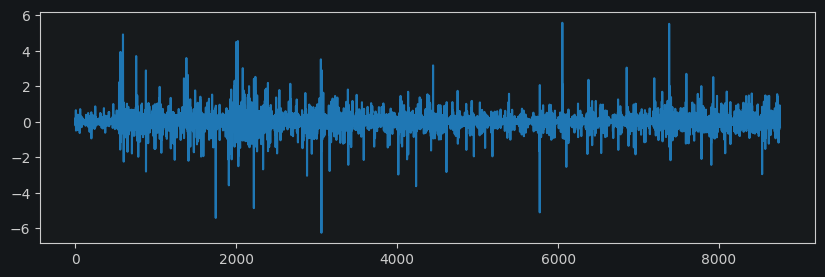

In [33]:
change.plot(figsize=[10, 3]);

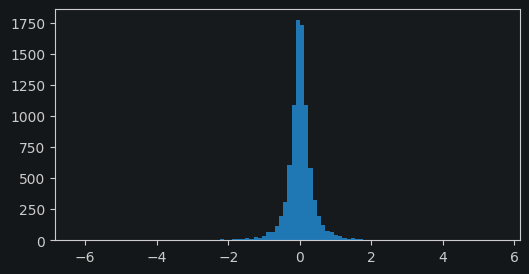

In [34]:
change.hist(figsize=[6, 3], bins=100, grid=False);

In [35]:
change.describe()

count    8760.000000
mean        0.011693
std         0.453030
min        -6.258745
25%        -0.149832
50%         0.006633
75%         0.165508
max         5.563792
dtype: float64

In [36]:
df['target'].value_counts(normalize=True) * 100

target
0    78.344749
1    21.655251
Name: proportion, dtype: float64

# Feature engineering
Создание признаков

In [37]:
WINDOW = 24

## RSI
Relative strength index
Индекс относительной силы

In [38]:
df['rsi'] = get_rsi(df, WINDOW)

In [39]:
df.tail(3)

,open_ts,open_price,high_price,low_price,close_price,target,rsi
8757,1703052000000,42740.0,43056.9,42656.1,42901.7,1,0.491854
8758,1703055600000,42901.6,42994.8,42823.7,42950.0,0,0.532505
8759,1703059200000,42950.0,43037.2,42772.7,42814.8,0,0.489905


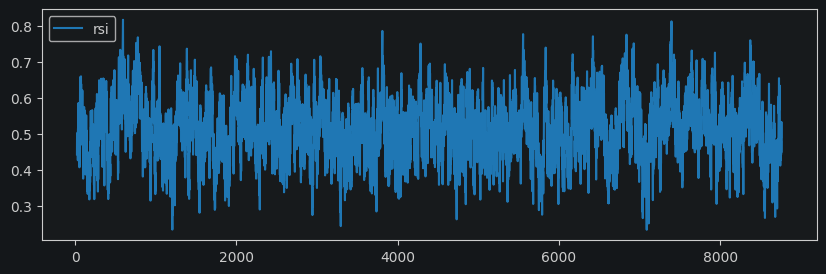

In [40]:
df[['rsi']].plot(figsize=[10, 3]);

## STH
Stochastic oscillator
Стохастический осциллятор

In [41]:
df['sth'] = get_sth(df, WINDOW)

In [42]:
df.tail(3)

,open_ts,open_price,high_price,low_price,close_price,target,rsi,sth
8757,1703052000000,42740.0,43056.9,42656.1,42901.7,1,0.491854,0.729493
8758,1703055600000,42901.6,42994.8,42823.7,42950.0,0,0.532505,0.762537
8759,1703059200000,42950.0,43037.2,42772.7,42814.8,0,0.489905,0.670042


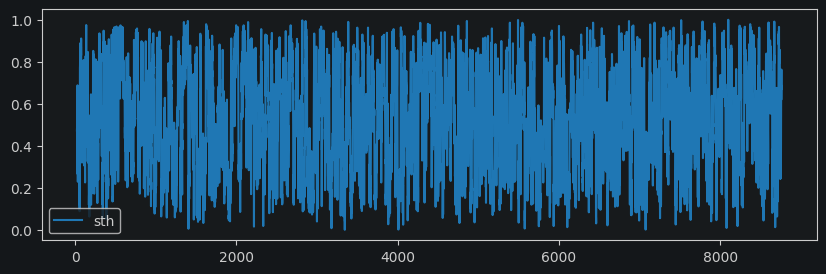

In [43]:
df[['sth']].plot(figsize=[10, 3]);

# Data gaps handling
Обработка пропусков

In [44]:
df = df[~df.isna().any(axis=1)]

In [45]:
df.shape

(8737, 8)

In [46]:
df['target'].value_counts(normalize=True) * 100

target
0    78.333524
1    21.666476
Name: proportion, dtype: float64

# Outliers handling
Обработка выбросов

## RSI

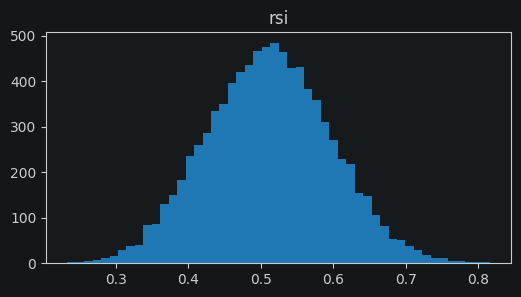

In [47]:
df[['rsi']].hist(figsize=[6, 3], bins=50, grid=False);

In [48]:
df['rsi'].describe()

count    8737.000000
mean        0.511209
std         0.084976
min         0.233269
25%         0.453103
50%         0.511168
75%         0.568742
max         0.816004
Name: rsi, dtype: float64

In [49]:
df.query('0 > rsi > 1').shape

(0, 8)

In [50]:
df = df.query('0 <= rsi <= 1')
df.head(3)

,open_ts,open_price,high_price,low_price,close_price,target,rsi,sth
23,1671609600000,16809.1,16889.2,16788.0,16856.8,1,0.442538,0.472648
24,1671613200000,16856.7,16874.6,16839.4,16861.3,0,0.487135,0.484956
25,1671616800000,16861.2,16874.6,16844.0,16853.5,0,0.448164,0.463621


## STH

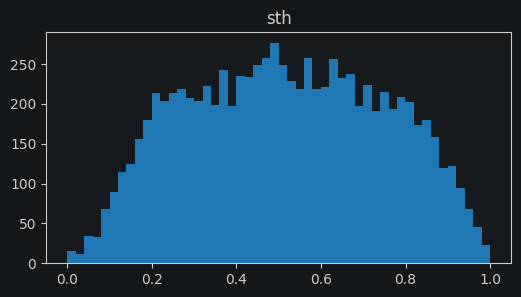

In [51]:
df[['sth']].hist(figsize=[6, 3], bins=50, grid=False);

In [52]:
df['sth'].describe()

count    8737.000000
mean        0.516334
std         0.230756
min         0.000000
25%         0.328166
50%         0.512688
75%         0.702680
max         0.999554
Name: sth, dtype: float64

In [53]:
df.query('0 > sth > 1').shape

(0, 8)

In [54]:
df = df.query('0 <= sth <= 1')
df.head(3)

,open_ts,open_price,high_price,low_price,close_price,target,rsi,sth
23,1671609600000,16809.1,16889.2,16788.0,16856.8,1,0.442538,0.472648
24,1671613200000,16856.7,16874.6,16839.4,16861.3,0,0.487135,0.484956
25,1671616800000,16861.2,16874.6,16844.0,16853.5,0,0.448164,0.463621


# Analysis
Анализ

## RSI

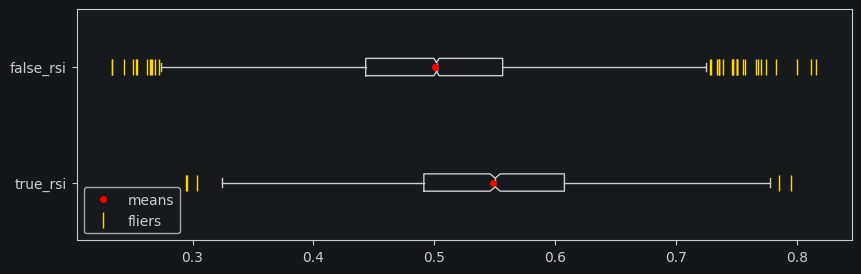

In [55]:
fig, ax = plt.subplots(figsize=[10, 3])
true_rsi = df['rsi'][df['target'] == True]
false_rsi = df['rsi'][df['target'] == False]
data = [true_rsi, false_rsi]
labels = ['true_rsi', 'false_rsi']
flierprops = {'marker': '|', 'ms': 12, 'mew': 1, 'mfc': 'gold', 'mec': 'gold'}
meanprops = {'marker': 'o', 'ms': 5, 'mew': 0, 'mfc': 'red', 'mec': 'red'}
boxprops = {'c': [0.8, 0.8, 0.8]}
whiskerprops = {'c': [0.8, 0.8, 0.8]}
capprops = {'c': [0.8, 0.8, 0.8]}
medianprops = {'c': [0.8, 0.8, 0.8]}
bp = ax.boxplot(
    x=data, vert=False, notch=True, showmeans=True, labels=labels,
    flierprops=flierprops, meanprops=meanprops, boxprops=boxprops,
    whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops
)
ax.legend([bp['means'][0], bp['fliers'][0]], ['means', 'fliers'], loc='lower left')
plt.show()

## STH

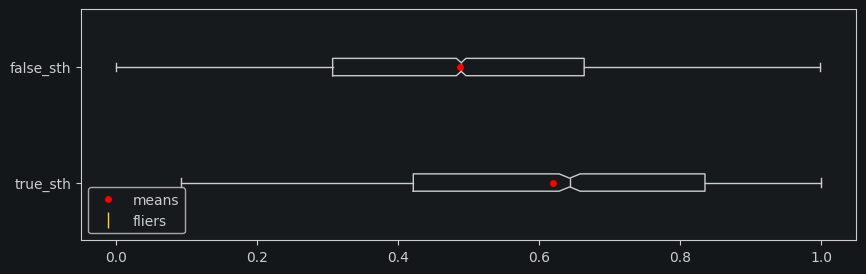

In [56]:
fig, ax = plt.subplots(figsize=[10, 3])
true_sth = df['sth'][df['target'] == True]
false_sth = df['sth'][df['target'] == False]
data = [true_sth, false_sth]
labels = ['true_sth', 'false_sth']
flierprops = {'marker': '|', 'ms': 12, 'mew': 1, 'mfc': 'gold', 'mec': 'gold'}
meanprops = {'marker': 'o', 'ms': 5, 'mew': 0, 'mfc': 'red', 'mec': 'red'}
boxprops = {'c': [0.8, 0.8, 0.8]}
whiskerprops = {'c': [0.8, 0.8, 0.8]}
capprops = {'c': [0.8, 0.8, 0.8]}
medianprops = {'c': [0.8, 0.8, 0.8]}
bp = ax.boxplot(
    x=data, vert=False, notch=True, showmeans=True, labels=labels,
    flierprops=flierprops, meanprops=meanprops, boxprops=boxprops,
    whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops
)
ax.legend([bp['means'][0], bp['fliers'][0]], ['means', 'fliers'], loc='lower left')
plt.show()

# Target-features split
Разделение признаков и целевой переменной

In [57]:
features = ['rsi', 'sth']
x_full = df[features]
y_full = df['target']

# Train-test split
Подготовка тренировочных и тестовых данных

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x_full, y_full, test_size=0.2, shuffle=False)
x_train = x_train.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [59]:
y_train.value_counts(normalize=False)

target
0    5555
1    1434
Name: count, dtype: int64

In [60]:
# Проверка функции get_balanced_weights

w_train = get_balanced_weights(y_train)
weights, counts = np.unique(ar=w_train, return_counts=True)
weights * counts

array([1434., 1434.])

In [61]:
y_test.value_counts(normalize=True)

target
0    0.737414
1    0.262586
Name: proportion, dtype: float64

# Modeling
Моделирование

## Models preparation
Подготовка моделей

In [98]:
models = []

In [99]:
transformers = [
    ('standard_scaler', StandardScaler(), ['rsi', 'sth']),
]
transformer = ColumnTransformer(transformers=transformers)

In [100]:
type_ = 'lrc'
c_list = [0.01, 0.1, 1, 10]
for c in c_list:
    params = dict(
        C=c
    )
    lrc = LogisticRegression(class_weight='balanced', max_iter=10_000, random_state=0, **params)
    model = dict(
        type=type_,
        params=params,
        name=f'{type_} {str(params)}',
        pipeline=get_pipeline(transformer, lrc)
    )
    models.append(model)

In [101]:
type_ = 'mlp'
layer_sizes_list = [[], [1], [3], [3, 2]]
for layer_sizes in layer_sizes_list:
    params = dict(
        layer_sizes=layer_sizes,
    )
    mlp = MLP(**params)
    model = dict(
        type=type_,
        params=params,
        name=f'{type_} {str(params)}',
        pipeline=get_pipeline(transformer, mlp)
    )
    models.append(model)

In [102]:
type_ = 'rfc'
max_features_list = [1, 2]
max_samples_list = [0.1, 0.2]
for max_features in max_features_list:
    for max_samples in max_samples_list:
        params = dict(
            max_features=max_features,
            max_samples=max_samples
        )
        rfc = RandomForestClassifier(class_weight='balanced_subsample', random_state=0, **params)
        model = dict(
            type=type_,
            params=params,
            name=f'{type_} {str(params)}',
            pipeline=get_pipeline(transformer, rfc)
        )
        models.append(model)

In [103]:
type_ = 'lgc'
strategy_list = ['bagging', 'goss']
num_leaves_list = [2, 3]
for strategy in strategy_list:
    for num_leaves in num_leaves_list:
        params = dict(
            data_sample_strategy=strategy,
            num_leaves=num_leaves
        )
        lgc = LGBMClassifier(is_unbalance=True, random_state=0, verbosity=0, **params)
        model = dict(
            type=type_,
            params=params,
            name=f'{type_} {str(params)}',
            pipeline=get_pipeline(transformer, lgc)
        )
        models.append(model)

In [104]:
len(models)

16

## Cross-validation
Кросс-валидация

In [105]:
for i, model in enumerate(models):
    k_fold = KFold(n_splits=4, shuffle=False)
    cv_scores = cross_val_scores(model['pipeline'], x_train, y_train, cv=k_fold, scoring=roc_auc)
    model['cv_score_name'] = 'ROC-AUC'
    model['cv_scores'] = cv_scores
    model['avg_cv_score'] = cv_scores.mean()
    model['std_cv_score'] = cv_scores.std()
    j = i + 1
    s = len(models)
    r = j / s * 100
    print(f'Model: {j}|{s} ({r:.1f} %).', end='\r')

In [106]:
names = [model['name'] for model in models]
avg_scores = [model['avg_cv_score'] for model in models]
std_scores = [model['std_cv_score'] for model in models]

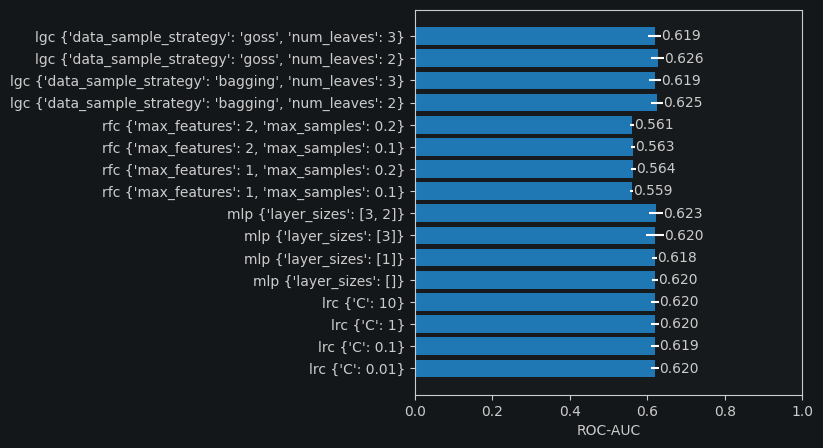

In [107]:
fig, ax = plt.subplots(figsize=(5, 5))
bars = ax.barh(y=names, width=avg_scores, xerr=std_scores, ecolor='w')
ax.bar_label(bars, fmt='%.3f')
ax.set_xlabel('ROC-AUC')
ax.set_xlim(0, 1)
plt.show()

## Best model selection
Выбор лучшей модели

In [108]:
best_model = None
best_score = 0

for model in models:
    if model['avg_cv_score'] > best_score:
        best_model = model
        best_score = model['avg_cv_score']

m = best_model['name']
n = best_model['cv_score_name']
a = best_model['avg_cv_score']
s = best_model['std_cv_score']

print(f'Best model: {m}.')
print(f'{n} = {a:.3f} ± {s:.3f} (cross-val).')

Best model: lgc {'data_sample_strategy': 'goss', 'num_leaves': 2}.
ROC-AUC = 0.626 ± 0.016 (cross-val).


## Best model evaluation
Оценка лучшей модели

In [109]:
best_model['pipeline'].fit(x_train, y_train)
p_test = best_model['pipeline'].predict(x_test)

In [110]:
r = roc_auc(y_test, p_test)
print(f'ROC-AUC = {r:.3f} (test).')

ROC-AUC = 0.634 (test).


In [111]:
p = precision(y_test, p_test)
print(f'precision = {p:.3f} (test).')

precision = 0.401 (test).


In [112]:
pd.crosstab(y_test, p_test, colnames=['predict'])

predict,0,1
target,,
0,898,391
1,197,262


## Precision & recall vs threshold

In [113]:
thresholds = np.arange(50, 101)
e_test = best_model['pipeline'].predict_proba(x_test)[:, 1]
precisions = np.array([precision(y_test, e_test > threshold, zero_division=np.nan) for threshold in thresholds / 100])
recalls = np.array([recall(y_test, e_test > threshold, zero_division=np.nan) for threshold in thresholds / 100])

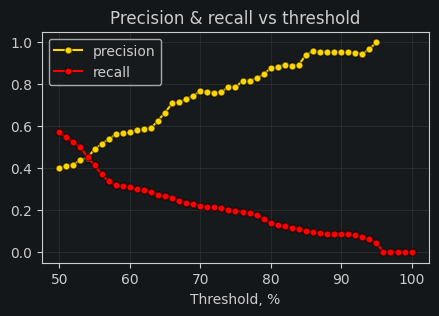

In [114]:
fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(thresholds, precisions, c='gold', marker='o', ms=5, mew=1, mec=[0, 0, 0, 0.5], label='precision')
ax.plot(thresholds, recalls, c='red', marker='o', ms=5, mew=1, mec=[0, 0, 0, 0.5], label='recall')
ax.grid(color=[1, 1, 1], alpha=0.1, lw=0.5)
ax.set_xlabel('Threshold, %')
ax.set_title('Precision & recall vs threshold')
ax.legend()
plt.show()

# Permutation importances

In [117]:
importances = permutation_importances(estimator=best_model['pipeline'], x=x_train, y=y_train, scoring=roc_auc, n_repeats=10)

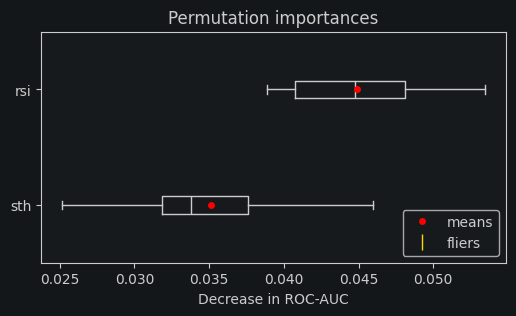

In [118]:
fig, ax = plt.subplots(figsize=[6, 3])
indices = importances['importances_mean'].argsort()
data = importances['importances'][indices].T
labels = importances['features'][indices]
flierprops = {'marker': '|', 'ms': 12, 'mew': 1, 'mfc': 'gold', 'mec': 'gold'}
meanprops = {'marker': 'o', 'ms': 5, 'mew': 0, 'mfc': 'red', 'mec': 'red'}
boxprops = {'c': [0.8, 0.8, 0.8]}
whiskerprops = {'c': [0.8, 0.8, 0.8]}
capprops = {'c': [0.8, 0.8, 0.8]}
medianprops = {'c': [0.8, 0.8, 0.8]}
bp = ax.boxplot(
    x=data, vert=False, notch=False, showmeans=True, labels=labels,
    flierprops=flierprops, meanprops=meanprops, boxprops=boxprops,
    whiskerprops=whiskerprops, capprops=capprops, medianprops=medianprops
)
ax.set_xlabel('Decrease in ROC-AUC')
ax.set_title('Permutation importances')
ax.legend([bp['means'][0], bp['fliers'][0]], ['means', 'fliers'], loc='lower right')
plt.show()